# Section 4


This file runs the experiments and returns the top performing models as a dictionary of hyper-parameters. It also creates all figures in the paper (except for those specific to the causal PDP and CD diagrams).

In [ ]:
# required modules (skip if already installed)
!pip install lightgbm
!pip install xgboost
!pip install optuna
!pip install scikit_posthocs
!pip install autorank
!pip install pytorch-tabnet

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# imports
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# local imports
from _utils import *

# settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 500)
np.set_printoptions(threshold=sys.maxsize)

# plot settings  
plt.style.use('seaborn-whitegrid') # https://matplotlib.org/devdocs/gallery/style_sheets/style_sheets_reference.html
plt.rc('font', size=16)
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=10)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [ ]:
# os.chdir("..")
# wd = os.getcwd()
# os.getcwd()

## Data preliminaries

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'lar_fl_adult.csv'), sep='|', )
df.head(5)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,Y
0,30.0,1.0,17.0,5.0,4030.0,315.0,0.0,30.0,2.0,8.0,False
1,78.0,1.0,21.0,1.0,2750.0,25.0,0.0,1.0,1.0,1.0,False
2,68.0,1.0,19.0,1.0,4900.0,44.0,1.0,12.0,2.0,1.0,False
3,20.0,1.0,19.0,5.0,4110.0,12.0,0.0,30.0,2.0,1.0,False
4,57.0,1.0,18.0,3.0,3930.0,12.0,0.0,42.0,2.0,2.0,True


In [10]:
"""
AGEP (Age); [cont.] 
COW (Class of worker); [cat.]
SCHL (Educational attainment); [cat.: ordinal] 
MAR (Marital status); [cat.]
OCCP (Occupation); [cat.: ordinal] 
POBP (Place of birth); [cat.]
RELP (Relationship); [cat.]
WKHP (Usual hours worked per week past 12 months); [cont.]
SEX (Sex); [cat.]
RAC1P (Recoded detailed race code) [cat.]
"""

target = 'Y'

con_feats = ['AGEP', 'WKHP']
cat_feats = ['COW', 'MAR', 'POBP', 'RELP', 'SEX', 'RAC1P']
ord_feats = ['SCHL', 'OCCP']
all_feats =  con_feats + cat_feats + ord_feats

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97238 entries, 0 to 97237
Data columns (total 11 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AGEP    float64
 1   COW     float64
 2   SCHL    float64
 3   MAR     float64
 4   OCCP    float64
 5   POBP    float64
 6   RELP    float64
 7   WKHP    float64
 8   SEX     float64
 9   RAC1P   float64
 10  Y       int64  
dtypes: float64(10), int64(1)
memory usage: 8.2 MB


In [4]:
# missing values?
if df[df.isna().any(axis=1)].shape[0] > 0:
    # replace missings with mode
    for c in df.columns[df.isnull().any()]:
        df[c].fillna(df[c].mode()[0], inplace=True)
else:
    print('no missing values')

no missing values


In [5]:
# TODO: not fully convinced on the treatment of ordinal vs categorical vars here! 
# check with Salvatore; also: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

# Check which variables are not numeric
print(df.select_dtypes(exclude = np.number).columns)

df['Y'] = df['Y'].map({False: 0, True: 1})
# df['SEX'] = df['SEX'].map({2: 'Female', 1: 'Male'})
# df['RAC1P'] = df['RAC1P'].ma({1: 'White', 2: 'Black', 3: 'Native', 4: 'Native', 5: 'Native', 6: 'Asian', 7: 'Islander', 8: 'Other', 9: 'Mixed'})

# Check which variables are not numeric
print(df.select_dtypes(exclude = np.number).columns)

df.head(5)

Index(['Y'], dtype='object')
Index([], dtype='object')


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,Y
0,30.0,1.0,17.0,5.0,4030.0,315.0,0.0,30.0,2.0,8.0,0
1,78.0,1.0,21.0,1.0,2750.0,25.0,0.0,1.0,1.0,1.0,0
2,68.0,1.0,19.0,1.0,4900.0,44.0,1.0,12.0,2.0,1.0,0
3,20.0,1.0,19.0,5.0,4110.0,12.0,0.0,30.0,2.0,1.0,0
4,57.0,1.0,18.0,3.0,3930.0,12.0,0.0,42.0,2.0,2.0,1


## Feature analysis

In [6]:
#Feature importance based on average precision of a classifier on the single feature
def test_proc(clf, X, y):
    # something close to: res =cross_val_score(clf, X, y, cv=10, scoring=score_metric)
    res_auc = res_avg = []
    for ite in range(0, 10):
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state=ite)
        for train, test in skf.split(X, y):
                X_train = X.iloc[train]
                y_train = y.iloc[train]
                X_test = X.iloc[test]
                y_test = y.iloc[test]
                clf.fit(X_train, y_train)
                y_scores = clf.predict_proba(X_test)[:,1] 
                avg_pr = average_precision_score(y_test, y_scores, sample_weight=None)
                res_avg.append(avg_pr)
                precision, recall, _ = precision_recall_curve(y_test, y_scores, sample_weight=None)
                auc_pr = auc(recall, precision)           
                res_auc.append(auc_pr)           
    # mean
    m = statistics.mean(res_auc)
    # standard deviation over the folds
    s = statistics.stdev(res_auc)
    # ci lower
    ci = ci_auc(res_avg, npos=sum(y))
    l = ci[2]
    u = ci[3]
    return (m, s, l, u)

In [11]:
#Feature importance using logistic regression on Theme columns
clf = LogisticRegression(solver='lbfgs', random_state=0)
roc = dict()
for b in all_feats:
    m, s, l, u = test_proc(clf, df[[b]], df[target])
    roc[b] = (m, s, l, u)

SCHL: PR AUC=0.532 +/- 0.021 CI=(0.529, 0.534498)
OCCP: PR AUC=0.528 +/- 0.008 CI=(0.526, 0.528614)
MAR: PR AUC=0.499 +/- 0.105 CI=(0.484, 0.513638)
RELP: PR AUC=0.493 +/- 0.100 CI=(0.479, 0.507086)
WKHP: PR AUC=0.486 +/- 0.019 CI=(0.484, 0.488941)
RAC1P: PR AUC=0.480 +/- 0.143 CI=(0.460, 0.499703)
SEX: PR AUC=0.457 +/- 0.102 CI=(0.443, 0.471652)
AGEP: PR AUC=0.408 +/- 0.006 CI=(0.408, 0.409248)
COW: PR AUC=0.341 +/- 0.005 CI=(0.340, 0.341775)
POBP: PR AUC=0.314 +/- 0.009 CI=(0.313, 0.315551)


(0.0, 1.0)

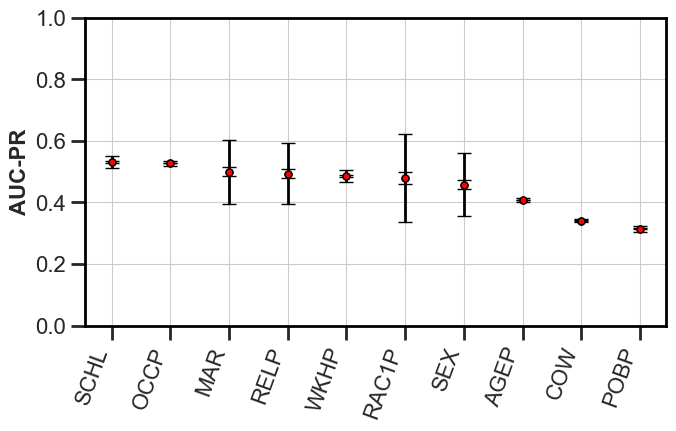

In [16]:
#Plot feature importance for themes
plt.figure(figsize=(7.5,4))
labels = []
i = 1
for b, v in sorted(roc.items(), key=lambda kv: kv[1][0], reverse=True):
    print('%s: PR AUC=%.3f +/- %.3f CI=(%.3f, %3f)' % (b, v[0], v[1], v[2], v[3]))
    plt.errorbar([i], [v[0]], yerr= [ [v[1]], [v[1]] ], c='black', fmt='o', mfc='red', markersize=5, capsize=5) # error bar
    plt.errorbar([i], [v[0]], yerr= [ [v[0]-v[2]], [v[3]-v[0]] ], c='black', fmt='o', mfc='red', markersize=5, capsize=5) # ci bars
    labels.append(b)
    i += 1
plt.xticks(range(1, i), labels, rotation=70, ha='right')
plt.ylabel('AUC-PR', fontweight="bold")
plt.ylim(0,1)
# plt.savefig(resu_path+'sec4/uniaucpr.pdf', bbox_inches='tight', dpi=400)

## Run experiments

In [17]:
# set weights
weight_column = None
# weight_column = df["Weight"] 
if weight_column is not None:
    print('Positive rate', sum(weight_column[df[target]==1])/sum(weight_column))
# simulate weights for TABNET
simulate_weights = True

In [18]:
num_repeat = 10

# Amount of trials/hyperparameter configurations per classifier
n_trials = 50

# Number of folds in StratifiedK cross-validation used when evaluating each classifier type
stratified_folds_cv = 10

# Number of cross-validation folds used when evaluating each trial within Optuna
trial_cv = 3

# Classifiers to experiment with
clf_names = ["LGBM2", 'LGBM', "LR", "RF", "DT", "XGB", "KNN", "TABNET"]

In [ ]:
import time

experiment_results = [] # store incrementally the results of experiments

for dataset_version, dataset in datasets.items():
    print('Dataset version', dataset_version)
    
    # Create our X and y from the selected dataset
    X = dataset.copy()
    y = dataset[target]
    X.drop(columns = [target], inplace = True)
    
    # Drop the correlated features
    #X = drop_correlated_features(X, .75)
       
    for rep in range(0, num_repeat):
        skf = StratifiedKFold(n_splits = stratified_folds_cv, shuffle = True, random_state=rep)
        for fold, (train, test) in enumerate(skf.split(X, y)):

            # train, test contain position based indexes of the sets
            X_train = X.iloc[train]
            y_train = y.iloc[train]
            sw_train = weight_column.iloc[train] if weight_column is not None else None

            X_test = X.iloc[test]
            y_test = y.iloc[test]
            sw_test = weight_column.iloc[test] if weight_column is not None else None
                        
            if simulate_weights:
                X_train = X_train.copy()
                X_train[target] = y_train
                wc = (sw_train/min(sw_train)).astype('int32')
                X_train = X_train.loc[X_train.index.repeat(wc)].reset_index(drop=True)
                y_train = X_train[target]
                X_train.drop(columns = [target], inplace = True)
                sw_train = None
                print(X_train.shape)

            # Try all classifiers
            for clf_name in clf_names:
                start = time.time()

                # "LGBM" is lightgbm with specialized optuna_study hyperparameter search (not included in the paper)
                # "LGBM2" is lightgbm with normal optuna_study hyperparameter search
                if clf_name == "LGBM":
                    #Hyperparameter optimization just on the trainset of the fold
                    experiment_result = optuna_study_lgbm(categorical_columns, trial_cv, X_train, y_train, sw_train)        
                else:
                    #Hyperparameter optimization just on the trainset of the fold
                    experiment_result = optuna_study_normal(clf_name, categorical_columns, trial_cv, n_trials, X_train, y_train, sw_train)

                experiment_result["dataset"] = dataset_version

                #Build the model with build_opt_clf(string, dictionary)
                clf = build_model(experiment_result['clf_name'], categorical_columns, experiment_result['best_hyparams'])

                #The model now has to learn the parameters from the training set
                if sw_train is not None:
                    clf.fit(X_train, y_train, clf__sample_weight=sw_train)
                else:
                    clf.fit(X_train, y_train)

                end = time.time()

                # Evaluate the model on the test set (not seen by optuna)
                #predict_proba returns ndarray of probs of shape (n_samples, n_classes)
                y_scores = clf.predict_proba(X_test)[:,1] 

                #AUPR curve computed using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
                #compares the ground truth with predicted probabilities     
                ap = average_precision_score(y_test, y_scores, sample_weight=sw_test)
                precision, recall, _ = precision_recall_curve(y_test, y_scores, sample_weight=sw_test)
                auc_pr = auc(recall, precision)

                #add to experiment_result dictionary (output of optuna_study) a new key:value pair (metric_test)
                experiment_result['fold'] = rep*stratified_folds_cv+fold
                experiment_result['auc_pr_test'] = auc_pr
                experiment_result['ap_test'] = ap
                experiment_result['elapsed'] = end - start
                #experiment_result['clf'] = clf
                experiment_result['train'] = train
                experiment_result['test'] = test

                #add the dictionary to the experiment_results list
                experiment_results.append(experiment_result)

                print(dataset_version, clf_name, 'fold', experiment_result['fold'], 'metrics', auc_pr, ap, end - start)